In [1]:
# Импорт библиотек
import os
import time
import KU_TU
import GTU
import SP
import mat_properties as prop
import numpy as n
import pandas as pd
from scipy.optimize import root

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel(
    "streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)

# Состав газов в номинале
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = (
    gas_streams0.at["GTU-PEVD", "N2"],
    gas_streams0.at["GTU-PEVD", "O2"],
    gas_streams0.at["GTU-PEVD", "CO2"],
    gas_streams0.at["GTU-PEVD", "H2O"],
    gas_streams0.at["GTU-PEVD", "Ar"],
)

gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure = gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies

############################################################
# Расчет ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, GTU_input, "GTU-KU")
Gas_turbine_res = Gas_turbine.calc()
electric.at["GTU", "N"] = Gas_turbine_res["N"]
electric.at["GTU", "KPD"] = Gas_turbine_res["eff"]
electric.at["DK", "N"] = Gas_turbine_res["Ndk"]
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
gas_streams.at["GTU-KU", "T"] = Gas_turbine_res["T"]
gas_streams.at["GTU-KU", "G"] = Gas_turbine_res["G"]
gas_streams.at["GTU-KU", "P"] = 0.1
gas_streams.at['GTU-KU', 'H'] = gas0.p_t(
    gas_streams.at['GTU-KU', 'P'], gas_streams.at['GTU-KU', 'T'])['h']
Gas_turbine_composition = pd.read_excel(
    "input.xlsx", sheet_name="Gas_composition0", index_col=0)

# Параметры газа на выходе в КУ
gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
gas_streams.at["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
gas_streams.at["GTU-PEVD",
               "N2":"Ar"] = Gas_turbine_composition.loc["Fraction", "N2":"Ar"]

############################################################
#Теплосеть
gas_streams.at["AIR", "T":"P"] = [GTU_input.loc["tair",1],0.1]
water_streams.at["AIR", "T":"P"] = [GTU_input.loc["tair",1],0.1]
Tnv = gas_streams.at["AIR", "T"]
water_streams.at["SWIN-TURB", "T"] = SP.Tset(Tnv)[1]
water_streams.at["SP2-WOUT", "T"] = SP.Tset(Tnv)[0]
# print(water_streams)
############################################################

# Состав газов при частичной нагрузке
fractiongas = (
    gas_streams.at["GTU-PEVD", "N2"],
    gas_streams.at["GTU-PEVD", "O2"],
    gas_streams.at["GTU-PEVD", "CO2"],
    gas_streams.at["GTU-PEVD", "H2O"],
    gas_streams.at["GTU-PEVD", "Ar"],
)
gas1 = prop.Materials_prop(
    gasmix,
    fractiongas,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Основные константы
Calcmethod = "hybr"
KPD_PN = 0.8074
KPD_KN = 0.75
KPD_to = 0.99
KPD_SP = 0.99

Calctolerance = 10**-2
Teplo = 0
Maxiterations_KU_TU = 20
Maxiterations_cotel = 5
Maxiterations_turbine = 30

#Claas KU+TU
KU_and_TU=KU_TU.ku_tu(gas0, gas1,  water, gas_streams0, gas_streams, water_streams0, water_streams, heaters, electric,Calcmethod, KPD_SP, KPD_KN, KPD_to, KPD_PN)

start_time = time.time()

KU_and_TU.calculate(Teplo,Calctolerance,Maxiterations_KU_TU,Maxiterations_cotel,Maxiterations_turbine)

print("Степень сухости пара в ЭВД: ", water.p_h(
    water_streams.at["EVD-IVD", "P"], water_streams.at["EVD-IVD", "H"])["Q"],)
print("Степень сухости пара в ГПК: ", water.p_h(
    water_streams.at["GPK-IND", "P"], water_streams.at["GPK-IND", "H"])["Q"],)

print(f"fin КУ и ТУ:--- {round((time.time() - start_time), 1)} сек. ---")

Достигнуто максимальное количество итераций контура низкого давления
Fin котел-утилизатора:--- 6.04 сек. ---
dQ/Qsumm 0.05972611253933968
Fin турбоустановка:--- 0.05 сек. ---
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура низкого давления
Повышена точность расчета котла для увеличения сходимости
dQ/Q ПЕВД+ИВД+ЭВД 2.3370347046944286
dQ/Q ПЕВД+ИВД+ЭВД -1.4102741286071803
dQ/Q ПЕВД+ИВД+ЭВД 0.7552751201927272
dQ/Q ПЕВД+ИВД+ЭВД -0.37133176576723004
dQ/Q ПЕВД+ИВД+ЭВД 0.17593458323205755
Достигнуто максимальное количество итераций контура высокого давления
dQ/Q ППНД+ИНД+ГПК 0.5148394754743084
dQ/Q ППНД+ИНД+ГПК -0.08986088215392735
Fin котел-утилизатора:--- 17.34 сек. ---
dQ/Qsumm 0.06817536919489091
Fin турбоустановка:--- 0.04 сек. ---
Достигнуто максимальное количество итераций контура высокого давления
Fin котел-утилизатора:--- 3.36 сек. ---
dQ/Qsumm

In [2]:
# Вывод газовых потоков
gas_streams

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,-3.100000,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,534.048296,0.1,949.368598,528.869414,0.7803,0.1237,0.0301,0.0594,0.0065
GTU-PEVD,534.048296,0.1,949.368598,528.869414,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,463.543368,0.1,868.929273,528.869414,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,309.549264,0.1,697.798463,528.869414,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,238.272657,0.1,620.627458,528.869414,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,235.403040,0.1,617.545148,528.869414,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,177.124043,0.1,555.319035,528.869414,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,105.973563,0.1,480.181961,528.869414,0.7803,0.1237,0.0301,0.0594,0.0065


In [3]:
# Вывод водяных потоков
water_streams

,T,P,H,G,S,X
AIR,-3.100000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,504.624801,8.425731,3405.907220,63.893835,NaN,NaN
IVD-PEVD,301.482898,8.768764,2746.735518,63.893835,NaN,NaN
EVD-IVD,299.934723,8.768764,1344.411729,63.893835,NaN,NaN
PEN-EVD,167.354181,8.768764,712.029359,63.893835,NaN,NaN
BND-PEN,165.860824,0.716019,700.991585,63.893835,NaN,NaN
PPND-DROSND,210.275008,0.710195,2867.619278,15.530863,NaN,NaN
IND-PPND,165.860824,0.716019,2763.705839,15.530863,NaN,NaN
GPK-IND,164.288992,0.716019,694.152187,79.424697,NaN,NaN
GPK-REC,164.288992,0.716019,694.152187,88.927332,NaN,NaN


In [4]:
Errors_water = abs(water_streams - water_streams0)/water_streams0*100
Errors_gas = abs(gas_streams-gas_streams0)/gas_streams0*100
Errors_gas
Errors_water

,G,H,P,S,T,X
AIR,NaN,NaN,NaN,NaN,NaN,NaN
BND-PEN,0.778919,0.703354,2.817152,NaN,0.681361,NaN
DOOTB1,1.618088,0.221545,1.622143,0.318484,NaN,NaN
DOOTB2,1.618088,0.236284,1.352162,0.311291,2.091606,NaN
DROSND-TURBND,5.222646,0.132605,2.189239,0.251051,0.691395,NaN
DROSVD-TURBVD,0.778919,0.485555,0.228558,NaN,1.310616,NaN
ENDOFVD,0.778919,0.304563,1.226057,NaN,1.936316,NaN
EVD-IVD,0.778919,0.483088,0.260274,NaN,0.379760,NaN
GPK-BYPASS,NaN,NaN,NaN,NaN,NaN,NaN
GPK-IND,1.618088,0.192887,2.817152,NaN,0.188948,NaN


In [5]:
gas_streams0

,T,P,H,G,N2,O2,CO2,H2O,Ar
GTU-KU,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GTU-PEVD,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,468.05,0.1,874.031830,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,309.20,0.1,697.417326,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,235.90,0.1,618.078812,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,233.00,0.1,614.965387,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,175.50,0.1,553.594555,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,106.90,0.1,481.155410,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
electric

,Ni,N,KPDm,KPD
PEN,0.705246,0.721883,0.976954,0.807400
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,165.660000,NaN,34.045225
DK,NaN,6.301381,NaN,NaN
Turbine,75.047318,NaN,NaN,NaN
Tots1,36.437678,NaN,NaN,0.849323
Tots2,9.805463,NaN,NaN,0.837228
Tots3,23.061891,NaN,NaN,0.814964
Tots4,5.742286,NaN,NaN,0.741099


In [7]:
heaters

,Qw,Qg,KPD
PEVD,42116.479636,42541.898622,0.99
IVD,89600.792563,90505.851074,0.99
EVD,40405.249989,40813.383827,0.99
PPND,1613.838534,1630.139933,0.99
IND,32580.392618,32909.487493,0.99
GPK,39340.323449,39737.700454,0.99
SP2,NaN,NaN,NaN
SP1,NaN,NaN,NaN
OD,NaN,NaN,NaN


In [8]:
GTU_input

,1,2,3,4,5,6
tair,-3.1,NaN,NaN,NaN,NaN,NaN
n,1.0,NaN,NaN,NaN,NaN,NaN
Pin,0.0,NaN,NaN,NaN,NaN,NaN
Pout,0.0,NaN,NaN,NaN,NaN,NaN


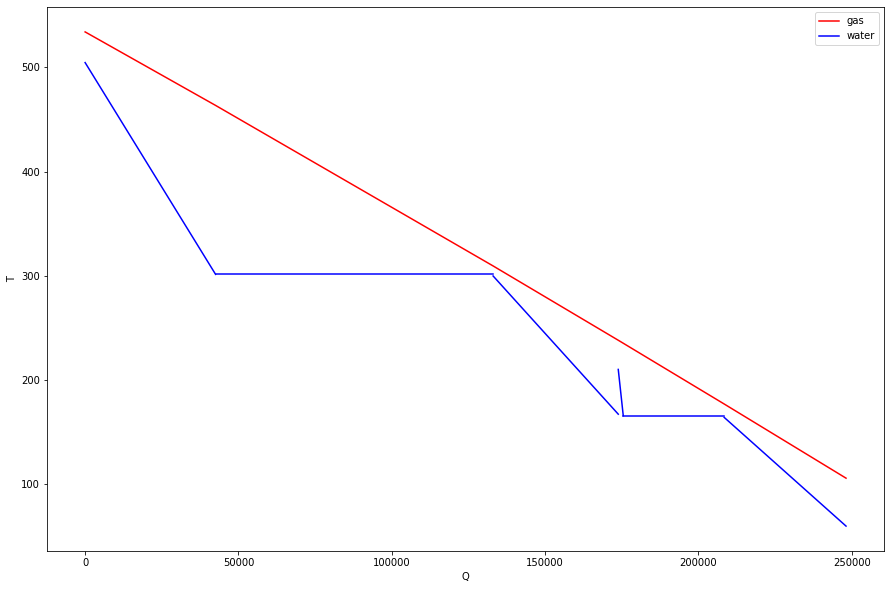

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
Qg = [0,
      heaters.loc['PEVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg']+heaters.loc['PPND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD',
                                                                     'Qg']+heaters.loc['PPND', 'Qg']+heaters.loc['IND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD', 'Qg'] +
      heaters.loc['PPND', 'Qg'] +
      heaters.loc['IND', 'Qg']+heaters.loc['GPK', 'Qg']
      ]
Qw = [0,
      heaters.loc['PEVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg'] +
      heaters.loc['EVD', 'Qg']+heaters.loc['PPND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD',
                                                                     'Qg']+heaters.loc['PPND', 'Qg']+heaters.loc['IND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD',
                                                                     'Qg']+heaters.loc['PPND', 'Qg']+heaters.loc['IND', 'Qg'],
      heaters.loc['PEVD', 'Qg']+heaters.loc['IVD', 'Qg']+heaters.loc['EVD', 'Qg'] +
      heaters.loc['PPND', 'Qg'] +
      heaters.loc['IND', 'Qg']+heaters.loc['GPK', 'Qg']
      ]
Tg = gas_streams.loc['GTU-PEVD':'GPK-out', 'T']
Tw = [water_streams.loc['PEVD-DROSVD', 'T'],
      water_streams.loc['IVD-PEVD', 'T'],
      water_streams.loc['IVD-PEVD', 'T'],
      water_streams.loc['EVD-IVD', 'T'],
      water_streams.loc['PEN-EVD', 'T'],
      water_streams.loc['PPND-DROSND', 'T'],
      water_streams.loc['IND-PPND', 'T'],
      water_streams.loc['IND-PPND', 'T'],
      water_streams.loc['GPK-REC', 'T'],
      water_streams.loc['REC-GPK', 'T'],
      ]
plt.plot(Qg, Tg, color='red')
plt.plot(Qw[0:2], Tw[0:2], color='blue')
plt.plot(Qw[1:3], Tw[1:3], color='blue')
plt.plot(Qw[3:5], Tw[3:5], color='blue')
plt.plot(Qw[5:7], Tw[5:7], color='blue')
plt.plot(Qw[6:8], Tw[6:8], color='blue')
plt.plot(Qw[8:10], Tw[8:10], color='blue')
plt.xlabel('Q')
plt.ylabel('T')
plt.legend(['gas', 'water'])
plt.show()

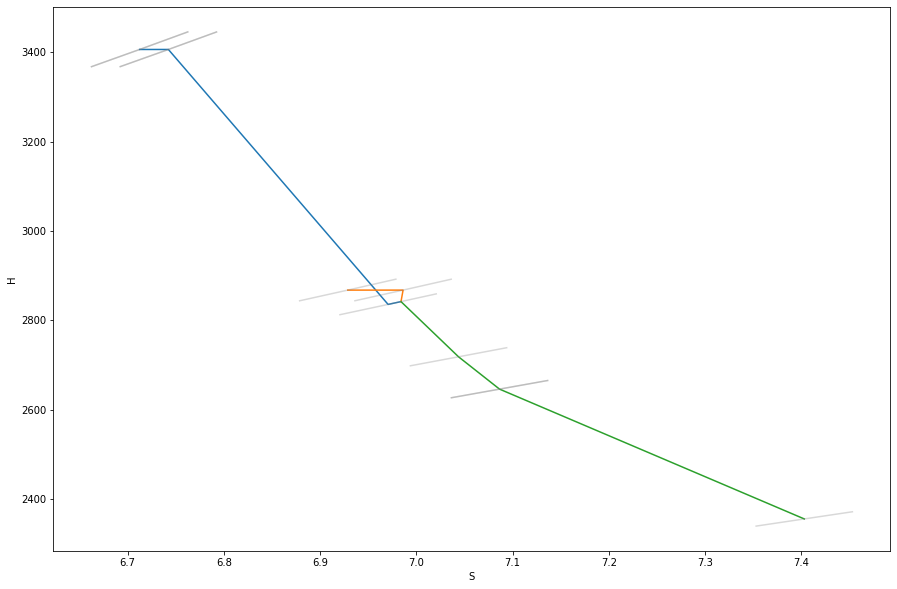

,T,P,H,G,S,X
AIR,-3.100000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,504.624801,8.425731,3405.907220,63.893835,6.712474,NaN
IVD-PEVD,301.482898,8.768764,2746.735518,63.893835,NaN,NaN
EVD-IVD,299.934723,8.768764,1344.411729,63.893835,NaN,NaN
PEN-EVD,167.354181,8.768764,712.029359,63.893835,NaN,NaN
BND-PEN,165.860824,0.716019,700.991585,63.893835,NaN,NaN
PPND-DROSND,210.275008,0.710195,2867.619278,15.530863,6.928698,NaN
IND-PPND,165.860824,0.716019,2763.705839,15.530863,NaN,NaN
GPK-IND,164.288992,0.716019,694.152187,79.424697,NaN,NaN
GPK-REC,164.288992,0.716019,694.152187,88.927332,NaN,NaN


In [24]:
import matplotlib.pyplot as plt


water_streams.at['PEVD-DROSVD', 'S'] = water.p_h(water_streams.at['PEVD-DROSVD', 'P'],water_streams.at['PEVD-DROSVD', 'H'])['s']
water_streams.at['PPND-DROSND', 'S'] = water.p_h(water_streams.at['PPND-DROSND', 'P'],water_streams.at['PPND-DROSND', 'H'])['s']

plt.figure(figsize=(15,10))
Hvd = [water_streams.at['PEVD-DROSVD', 'H'],
       water_streams.at['DROSVD-TURBVD', 'H'],
       water_streams.at['ENDOFVD', 'H'],
       water_streams.at['SMESHEND', 'H'],
]
Svd = [water_streams.at['PEVD-DROSVD', 'S'],
       water_streams.at['DROSVD-TURBVD', 'S'],
       water_streams.at['ENDOFVD', 'S'],
       water_streams.at['SMESHEND', 'S'],
]
Hsm = [water_streams.at['PPND-DROSND', 'H'],
       water_streams.at['DROSND-TURBND', 'H'],
       water_streams.at['SMESHEND', 'H'],
]
Ssm = [water_streams.at['PPND-DROSND', 'S'],
       water_streams.at['DROSND-TURBND', 'S'],
       water_streams.at['SMESHEND', 'S'],
]
Hnd = [water_streams.at['SMESHEND', 'H'],
       water_streams.at['DOOTB2', 'H'],
       water_streams.at['DOOTB1', 'H'],
       water_streams.at['INCND', 'H'],
       water_streams.at['INKOND', 'H'],
]
Snd = [water_streams.at['SMESHEND', 'S'],
       water_streams.at['DOOTB2', 'S'],
       water_streams.at['DOOTB1', 'S'],
       water_streams.at['INCND', 'S'],
       water_streams.at['INKOND', 'S'],
]

#Давления
stream = 'PEVD-DROSVD'
H1=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S1=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'DROSVD-TURBVD'
H2=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S2=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'ENDOFVD'
H3=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S3=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'PEVD-DROSVD'
H4=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S4=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'DROSVD-TURBVD'
H5=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S5=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'PPND-DROSND'
H6=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S6=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'DROSND-TURBND'
H7=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S7=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]

stream = 'DOOTB2'
H8=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S8=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'DOOTB1'
H9=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S9=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'INCND'
H10=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S10=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]
stream = 'INKOND'
H11=[water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']-0.05)['h'],water_streams.at[stream,'H'],water.p_s(water_streams.at[stream, 'P'],water_streams.at[stream, 'S']+0.05)['h']]
S11=[water_streams.at[stream, 'S']-0.05,water_streams.at[stream, 'S'],water_streams.at[stream, 'S']+0.05]


plt.plot(Svd,Hvd)
plt.plot(Ssm,Hsm)
plt.plot(Snd,Hnd)
plt.plot(S1,H1,S2,H2,S3,H3,S4,H4,S5,H5,S6,H6,S7,H7,S8,H8,S9,H9,S10,H10,S11,H11, color = "gray", alpha=0.3)
plt.xlabel('S')
plt.ylabel('H')
plt.show()
water_streams
